# Lab03: Decision Tree


Student ID: 21127347  

Student name: Đặng Hoàng Long

*This notebook is a lab assignment of the Artificial Intelligence course (CSC14003). The lab aims to familiarize students with the essence of Decision Trees, more specifically Iterative Dichotomiser 3 (ID3).*
During the lab, I've learned a few things:
- How to implement ID3 algorithm
- How to use ID3 algorithm to solve a classification problem
- How to evaluate the performance of a classifier using the confusion matrix, more specifically:
  - Accuracy
  - Precision
  - Recall
  - F1 score
- The math behind the ID3 algorithm, such as
  - Entropy
  - Information Gain


### Import library

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

### Load Iris dataset

In [2]:
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()

X=iris.data
y=iris.target

#split dataset into training data and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)

## 1. Decision Tree: Iterative Dichotomiser 3 (ID3)

### 1.1 Information Gain

Expected value of the self-information (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

The entropy function gets the smallest value if there is a value of $p_i$ equal to 1, reaches the maximum value if all $ p_i $ are equal. These properties of the entropy function make it is an expression of the disorder, or randomness of a system, ...

In [3]:
def entropy(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    entropy = 0
    for count in counts:
        if count != 0:
            entropy += -count/n_samples * np.log2(count/n_samples)
    return entropy


In [4]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    for c in n_classes:
        counts.append(sum(division==c))

    #calculate entropy of each class
    e = entropy(counts,n_samples)
    
    return e,n_samples


def get_entropy(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    entropy_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    entropy_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    # overall entropy
    s =  n_true/n * entropy_true + n_false/n * entropy_false
    
    return s

The information gain of classifying information set D by attribute A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

At each node in ID3, an attribute is chosen if its information gain is highest compare to others.

All attributes of the Iris set are represented by continuous values. Therefore we need to represent them with discrete values. The simple way is to use a `cutoff` threshold to separate values of the data on each attribute into two part:` <cutoff` and `> = cutoff`.

To find the best `cutoff` for an attribute, we replace` cutoff` with its values then compute the entropy, best `cutoff` achieved when value of entropy is smallest  $ \left (\arg \min Entrophy_ {A} (D) \right) $.

### 1.2 Decision tree

In [5]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node 
        
        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes, 
           if a node is leaf all data samples will have same label
        
        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''
        
        #Stop conditions
        
        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
               
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
         
        min_entropy = 10

        #Loop through col_data find cutoff where entropy is minimum


        for value in set(col_data):
            y_predict = col_data < value
            my_entropy = get_entropy(y_predict, y)
            #TODO
            if my_entropy < min_entropy:
                min_entropy = my_entropy
                cutoff = value
            
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.3 Classification on Iris Dataset

In [6]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))


Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.96


**TODO**: F1, Recall and Precision report

### 1.4 F1, Recall and Precision report

**Confusion Matrix**

In [7]:
from sklearn.metrics import confusion_matrix

# Load data
X = iris.data
y = iris.target

# Get shape of data
#print(X.shape)
#print(y)

# Predict and print out the result
y_pred = model.predict(X)
print("")
#print(y_pred)

# Get confusion matrix
print("Confusion matrix: ")
cm = confusion_matrix(y, y_pred)
print("")
print(cm)

# Get accuracy
print("")
print("Accuracy: ")
print(accuracy_score(y, y_pred))


Confusion matrix: 

[[50  0  0]
 [ 0 49  1]
 [ 0  1 49]]

Accuracy: 
0.9866666666666667


Let's get fancy and plot out the confusion matrix

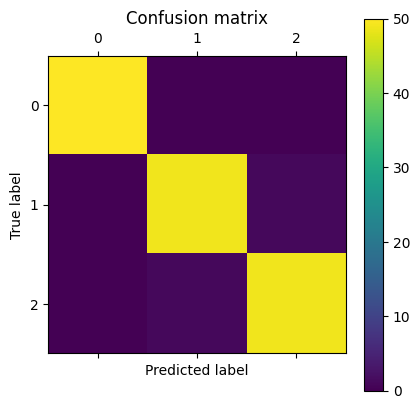

In [8]:
plt.matshow(cm, cmap=plt.cm.viridis)
plt.title('Confusion matrix')
plt.colorbar(format='%1.d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [9]:
# Print the confusion matrix again
print("Confusion Matrix: ")
print(cm)


# Get all the values from the confusion matrix

# Value for the first class
tp_1 = cm[0][0]
fn_1 = cm[0][1] + cm[0][2]
fp_1 = cm[1][0] + cm[2][0]
tn_1 = cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]

# Value for the second class
tp_2 = cm[1][1]
fn_2 = cm[1][0] + cm[1][2]
fp_2 = cm[0][1] + cm[2][1]
tn_2 = cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]

# Value for the third class
tp_3 = cm[2][2]
fn_3 = cm[2][0] + cm[2][1]
fp_3 = cm[0][2] + cm[1][2]
tn_3 = cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]

print("")
print("Class 1: ")
print("True Positive: ", tp_1)
print("False Negative: ", fn_1)
print("False Positive: ", fp_1)
print("True Negative: ", tn_1)

print("")
print("Class 2: ")
print("True Positive: ", tp_2)
print("False Negative: ", fn_2)
print("False Positive: ", fp_2)
print("True Negative: ", tn_2)

print("")
print("Class 3: ")
print("True Positive: ", tp_3)
print("False Negative: ", fn_3)
print("False Positive: ", fp_3)
print("True Negative: ", tn_3)

Confusion Matrix: 
[[50  0  0]
 [ 0 49  1]
 [ 0  1 49]]

Class 1: 
True Positive:  50
False Negative:  0
False Positive:  0
True Negative:  100

Class 2: 
True Positive:  49
False Negative:  1
False Positive:  1
True Negative:  99

Class 3: 
True Positive:  49
False Negative:  1
False Positive:  1
True Negative:  99


**Get accuracy, precision and recall scores for the prediction**
- *Accuracy*:

$$accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

- *Precision*:
$$precision=\frac{TP}{TP+FP}$$

- *Recall*:
$$recall=\frac{TP}{TP+FN}$$

We will use the above formulas to calculate the accuracy, precision and recall scores for the prediction.

In [10]:
# Get the metrics for each of the three classes
accuracy_1 = (tp_1 + tn_1) / (tp_1 + tn_1 + fp_1 + fn_1)
precision_1 = tp_1 / (tp_1 + fp_1)
recall_1 = tp_1 / (tp_1 + fn_1)
print("Accuracy for class 1: ", accuracy_1)
print("Precision for class 1: ", precision_1)
print("Recall for class 1: ", recall_1)

print("")
accuracy_2 = (tp_2 + tn_2) / (tp_2 + tn_2 + fp_2 + fn_2)
precision_2 = tp_2 / (tp_2 + fp_2)
recall_2 = tp_2 / (tp_2 + fn_2)
print("Accuracy for class 2: ", accuracy_2)
print("Precision for class 2: ", precision_2)
print("Recall for class 2: ", recall_2)

print("")
accuracy_3 = (tp_3 + tn_3) / (tp_3 + tn_3 + fp_3 + fn_3)
precision_3 = tp_3 / (tp_3 + fp_3)
recall_3 = tp_3 / (tp_3 + fn_3)
print("Accuracy for class 3: ", accuracy_3)
print("Precision for class 3: ", precision_3)
print("Recall for class 3: ", recall_3)

Accuracy for class 1:  1.0
Precision for class 1:  1.0
Recall for class 1:  1.0

Accuracy for class 2:  0.9866666666666667
Precision for class 2:  0.98
Recall for class 2:  0.98

Accuracy for class 3:  0.9866666666666667
Precision for class 3:  0.98
Recall for class 3:  0.98


Lastly, the formula for calculating the F1 score is:

$$F1 = 2 \times \frac{precision \times recall}{precision + recall}$$

F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

Let's calculate the F1 score for the classifier we trained on the last screen.

In [11]:
# Calculate F1 score for each class
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
f1_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2)
f1_3 = 2 * (precision_3 * recall_3) / (precision_3 + recall_3)

print("F1 score for class 1: ", f1_1)
print("F1 score for class 2: ", f1_2)
print("F1 score for class 3: ", f1_3)

F1 score for class 1:  1.0
F1 score for class 2:  0.98
F1 score for class 3:  0.98


### References
- [T. Tigerschiold, “What is Accuracy, Precision, Recall and F1 Score?,” Labelf.ai, Nov. 17, 2022. https://www.labelf.ai/blog/what-is-accuracy-precision-recall-and-f1-score (accessed Aug. 10, 2023)](https://www.labelf.ai/blog/what-is-accuracy-precision-recall-and-f1-score)  
  
- [“Precision, Recall, and F1 Score: When Accuracy Betrays You,” Proclus Academy, 2022. https://proclusacademy.com/blog/explainer/precision-recall-f1-score-classification-models/ (accessed Aug. 10, 2023)‌](https://proclusacademy.com/blog/explainer/precision-recall-f1-score-classification-models/)  
  
- [“Decision Trees: Information Gain.” Available: https://courses.cs.washington.edu/courses/cse446/20wi/Lecture3/03_InformationGain.pdf](https://courses.cs.washington.edu/courses/cse446/20wi/Lecture3/03_InformationGain.pdf)  
  
- [A. Kumar, “Accuracy, Precision, Recall & F1-Score - Python Examples - Data Analytics,” Data Analytics, Mar. 17, 2023. https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/. (accessed Aug. 10, 2023).‌](https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/)  
  
- [J. Starmer, “Entropy (for data science) Clearly Explained!!!,” YouTube. Aug. 24, 2021. Accessed: Aug. 10, 2023. [YouTube Video]. Available: https://www.youtube.com/watch?v=YtebGVx-Fxw](https://www.youtube.com/watch?v=YtebGVx-Fxw)  

- [
Bharathi, “Latest Guide on Confusion Matrix for Multi-Class Classification,” Analytics Vidhya, Jun. 24, 2021. https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/ (accessed Aug. 10, 2023).‌](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/)